# Model Testing

Here we will test different models to see which one performs best on our data. We will test different models:


We will work on already prepared dataset.

## Linear Regression

In [91]:
import pandas as pd
import numpy as np
import data_preprocessing as dp

jobs_df = pd.read_csv('data/cleared/linkedin_data.csv')

# Encoding categorical data - job titles
jobs_df = dp.encode_job_ttls(jobs_df)
jobs_df = jobs_df.drop(['Job_Desc', 'Job_Ttl', 'max_sal', 'min_sal', 'Co_Nm', 'py_prd', 'loc', 'wrk_typ'], axis=1)
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13211 entries, 0 to 13210
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Flw_Cnt        13211 non-null  int64  
 1   Is_Supvsr      13211 non-null  bool   
 2   med_sal        13211 non-null  float64
 3   st_code        13211 non-null  object 
 4   is_remote      13211 non-null  int64  
 5   views          13211 non-null  int64  
 6   xp_lvl         13211 non-null  object 
 7   mean_year_sal  13211 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 838.6+ KB


In [92]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Calculate mean 'med_sal' for each 'xp_lvl'
mean_sal_by_xp_lvl = jobs_df.groupby('xp_lvl')['med_sal'].mean()

# Calculate mean 'med_sal' for each 'st_code'
mean_sal_by_st_code = jobs_df.groupby('st_code')['med_sal'].mean()

# Add a new column 'mean_sal_by_st_code' to the DataFrame
jobs_df['mean_sal_by_st_code'] = jobs_df['st_code'].map(mean_sal_by_st_code)

# Add a new column 'mean_sal_by_xp_lvl' to the DataFrame
jobs_df['mean_sal_by_xp_lvl'] = jobs_df['xp_lvl'].map(mean_sal_by_xp_lvl)


# Make a copy of the DataFrame and drop the 'st_code' column
jobs_df_copy = jobs_df.copy()
jobs_df_copy = jobs_df_copy.drop(['st_code'], axis=1)

# Define the target variable 'y' and the feature matrix 'X'
y = jobs_df['med_sal'].values
X = jobs_df[['Flw_Cnt', 'Is_Supvsr', 'is_remote', 'views', 'mean_sal_by_xp_lvl', 'mean_sal_by_xp_lvl']].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

# Create and train a KNN regressor on the scaled data
regressor = KNeighborsRegressor(n_neighbors=5, metric='minkowski', p=2)
regressor.fit(X_train_scaled, y_train_scaled)

# Make predictions and print the mean squared error
y_pred = regressor.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred.flatten()
print('Mean squared error: ', mean_squared_error(y_test, y_pred))

# Perform 5-fold cross-validation
scores = cross_val_score(regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive and take the square root (to get the root mean squared error)
rmse_scores = np.sqrt(-scores)

print('RMSE scores: ', rmse_scores)
print('Mean RMSE: ', rmse_scores.mean())



Mean squared error:  2299597579.869973
RMSE scores:  [45653.88592635 44704.38363531 47898.49088028 46298.33968266
 46589.77343399]
Mean RMSE:  46228.974711716386


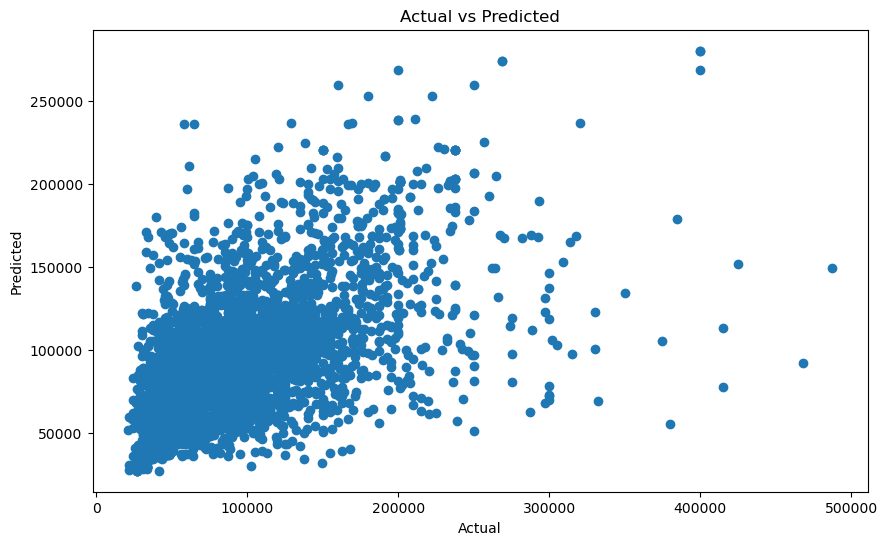

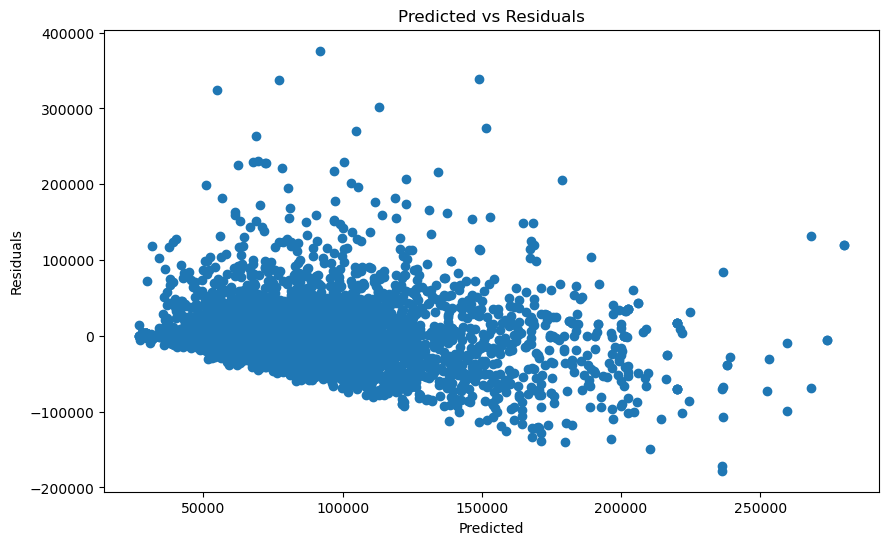

In [93]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.show()

The provided Python code is performing a regression task using a K-Nearest Neighbors (KNN) model to predict median salaries based on several job features. The code includes data preprocessing (such as feature scaling and splitting the data into training and testing sets), model training, prediction, and evaluation using Mean Squared Error (MSE) and cross-validation. The results indicate that the model's predictions have a high error rate, suggesting the need for model tuning or a different approach.

## Comments on the results

The Mean Squared Error (MSE) of 2193137615.069355 and the Root Mean Squared Error (RMSE) scores ranging from around 46135 to 47745 suggest that the model's predictions are not very accurate. The high error rates indicate that the KNN model may need further tuning or a different modeling approach might be more effective.


# Decision Tree Regression

In [94]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X, y)

# Print the best parameters
print('Best parameters: ', grid_search.best_params_)

# Train the DecisionTreeRegressor with the best parameters
best_regressor = grid_search.best_estimator_

# Make predictions and print the mean squared error
y_pred = best_regressor.predict(X_test_scaled)
print('Mean squared error: ', mean_squared_error(y_test, y_pred))

# Perform 5-fold cross-validation
scores = cross_val_score(best_regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive and take the square root (to get the root mean squared error)
rmse_scores = np.sqrt(-scores)

print('RMSE scores: ', rmse_scores)
print('Mean RMSE: ', rmse_scores.mean())

Best parameters:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mean squared error:  4276792659.0369225
RMSE scores:  [43851.00708362 42829.13393527 46840.08766996 45476.19718012
 46096.39909841]
Mean RMSE:  45018.56499347427


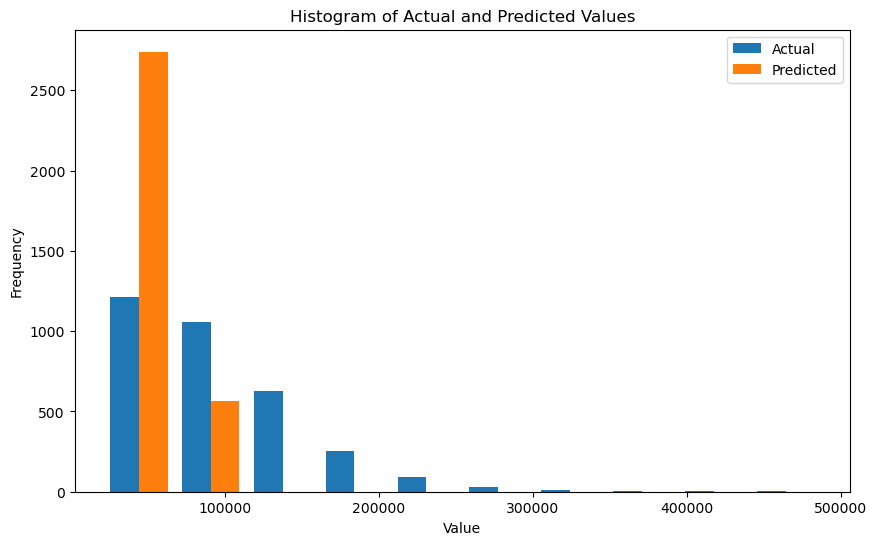

In [95]:
# Plot histogram of actual and predicted values
plt.figure(figsize=(10, 6))
plt.hist([y_test, y_pred], label=['Actual', 'Predicted'])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Actual and Predicted Values')
plt.legend()
plt.show()

## Comments on the results
The error rates are relatively high, suggesting there might be further room for improvement, possibly through additional feature engineering, trying different models.